# Movie Recommendation Systems


## Content-Based Recommender


**Content-based recommender** is the recommending system to rely on the similarity of items when it recommends items to users. For example, when a user likes a specific movie, the system finds and recommends the items which have similar features to the movie the user likes.


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read the Data


In [19]:
movies = pd.read_csv('../cleaned_data/movies_small.csv', usecols=['title','genres', 'overview', 'img_url'])
movies.head(2)

,title,img_url,genres,overview
0,The Kid,https://m.media-amazon.com/images/M/MV5BZjhhMT...,"Comedy,Drama,Family","The Tramp cares for an abandoned child, but ev..."
1,Sherlock Jr.,https://m.media-amazon.com/images/M/MV5BZWFhOG...,"Action,Comedy,Romance","A film projectionist longs to be a detective, ..."


### Explore the Feature (genres)


Each movie contains multiple genres as follows:


Let's see how many times each genre appears in the data.


In [20]:
movies['genres'] = movies['genres'].str.replace(',',' ')

Drama and Comedy are the most in the data set. About half of the movies in the data are categorized into Drama or Comedy.


### Term Frequency and Inverse Document Frequency (tf-idf)


The **TfidVectorizer()** class from the **sklearn.feature_extraction.text** library helps us to calculate the **tf-idf** scores for each genre in each movie.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
movies['genres'] = movies['genres'].str.replace('Sci-Fi','SciFi')
movies['genres'] = movies['genres'].str.replace('Film-Noir','FilmNoir')
movies['genres'] = movies['genres'].str.replace('Reality-TV','RealityTV')
movies['genres'] = movies['genres'].str.replace('Talk-Show','TalkShow')

In [23]:
# Combine 'overview' and 'genres' into a single column
movies['content'] = movies['overview'] + ' ' + movies['genres'] + ' ' + movies['title']

# Create a TF-IDF vectorizer
tfidf_vector = TfidfVectorizer(stop_words='english')

# Compute the TF-IDF matrix
tfidf_matrix = tfidf_vector.fit_transform(movies['content'])

In [24]:
tfidf_matrix.shape

(28296, 60727)

Next, let's caculate the similarity between two movies using the **tf-idf matrix**. The **cosine similarity** is used to calculate the similarity, and **linear_kernel()** class is used to calculate this.


In [25]:
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [26]:
# create the cosine similarity matrixs
sim_matrix = linear_kernel(tfidf_matrix,tfidf_matrix)
print(sim_matrix)

[[1.         0.00825673 0.0115408  ... 0.00347662 0.         0.004581  ]
 [0.00825673 1.         0.00486112 ... 0.06453774 0.00670834 0.        ]
 [0.0115408  0.00486112 1.         ... 0.00204685 0.00921235 0.00269705]
 ...
 [0.00347662 0.06453774 0.00204685 ... 1.         0.         0.00230246]
 [0.         0.00670834 0.00921235 ... 0.         1.         0.        ]
 [0.004581   0.         0.00269705 ... 0.00230246 0.         1.        ]]


**sim_matrix**$_{ij}$ is the similarity score between movie $i$ and movie $j$. Therefore, the diagonal elements in the matrix represent the similarity scores of a movie with itself, and therefore, the value should be 1. By the definition of the matrix, **sim_matrix**$_{ij}$ = **sim_matrix**$_{ji}$.


### Make the Recommendation Engine


When we use movie recommendation system, we type the title of the movie. However, the **sim_matrix** is based on the index of each movie. Therefore, we need to convert movie title into movie index and movie index into movie title. Let's create functions which operate those functions.


In [27]:
def get_movieimg_from_index(index):
  return movies[movies.index == index]['img_url'].values[0]

def get_index_from_title(title):
  return movies[movies.title == title].index.values[0]

def get_title_from_index(index):
  return movies[movies.index == index]['title'].values[0]

#### Apply Levenshtein Distance for 'Did you mean?' Algorithm


We often misspell titles of movies when we use movie recommending system. When we use _Google_ to search movies, if we misspell the title of the movie, we see that _Google_ asks us, _'Did you mean...?'_. Let's create the similar function to correct misspelled title in order to make the system work easily. I apply **Levenshtein Distance** in order to implement _'Did you mean...?'_ algorithm. **fuzzywuzzy** library in Python provides **fuzz** class for the **Levenshtein Distance**.


In [28]:
from fuzzywuzzy import fuzz

In [29]:
# function to find the closest title
def matching_score(a,b):
  return fuzz.ratio(a,b)

**fuzz.ratio(a,b)** calculates the Levenshtein Distance between **a** and **b**, and return the score for the distance. If the two words, **a** and **b**, are exactly the same, the score becomes 100. As the distance between the words increases, the score falls.


In [30]:
# function to return the most similar title to the words a user types
def find_closest_title(title):
  leven_scores = list(enumerate(movies['title'].apply(matching_score, b=title)))
  sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
  closest_title = get_title_from_index(sorted_leven_scores[0][0])
  distance_score = sorted_leven_scores[0][1]
  return closest_title, distance_score

The function **find_closest_title()** is supposed to return the most similar title to the words a user types. Without this, the recommending system only works when the movie title a user types is exactly the same as the movie title the system has.


#### Create the Recommending System


In [31]:
import urllib.request
from PIL import Image

In [32]:
def contents_based_recommender(movie, num_of_recomm=10):
    closest_title, distance_score = find_closest_title(movie)

    if distance_score == 100:
        movie_index = get_index_from_title(closest_title)
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
        similar_movies = list(filter(lambda x: x[0] != int(movie_index), sorted(movie_list, key=lambda x: x[1], reverse=True)))

        # Create a 2x5 subplot grid
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        fig.suptitle("Here's the list of movies similar to " + str(closest_title), fontsize=16)

        for i, s in enumerate(similar_movies[:num_of_recomm]):
            url = get_movieimg_from_index(s[0])
            ax = axes[i // 5, i % 5]
            ax.imshow(np.array(Image.open(urllib.request.urlopen(url))))
            plt.xlabel(get_title_from_index(s[0]))
            ax.axis('off')

        plt.show()
    else:
        print('Did you mean ' + '\033[1m' + str(closest_title) + '\033[0m' + '?', '\n')

        movie_index = get_index_from_title(closest_title)
        movie_list = list(enumerate(sim_matrix[int(movie_index)]))
        similar_movies = list(filter(lambda x: x[0] != int(movie_index), sorted(movie_list, key=lambda x: x[1], reverse=True)))

        # Create a 2x5 subplot grid
        fig, axes = plt.subplots(2, 5, figsize=(12, 6))
        fig.suptitle("Here's the list of movies similar to " + str(closest_title), fontsize=16)

        for i, s in enumerate(similar_movies[:num_of_recomm]):
            url = get_movieimg_from_index(s[0])
            ax = axes[i // 5, i % 5]
            ax.imshow(np.array(Image.open(urllib.request.urlopen(url))))
            plt.xlabel(get_title_from_index(s[0]))
            ax.axis('off')

        plt.show()


The recommending system returns the list of movies similar to the movie a user likes. It finds and recommends movies even if the user misspell the tile of the movie he or she likes. If the user misspell the title, the system finds the most similar title to the words the user types and recommends movies based on the movie it found alternatively.


#### Test the System


Did you mean Fatman? 



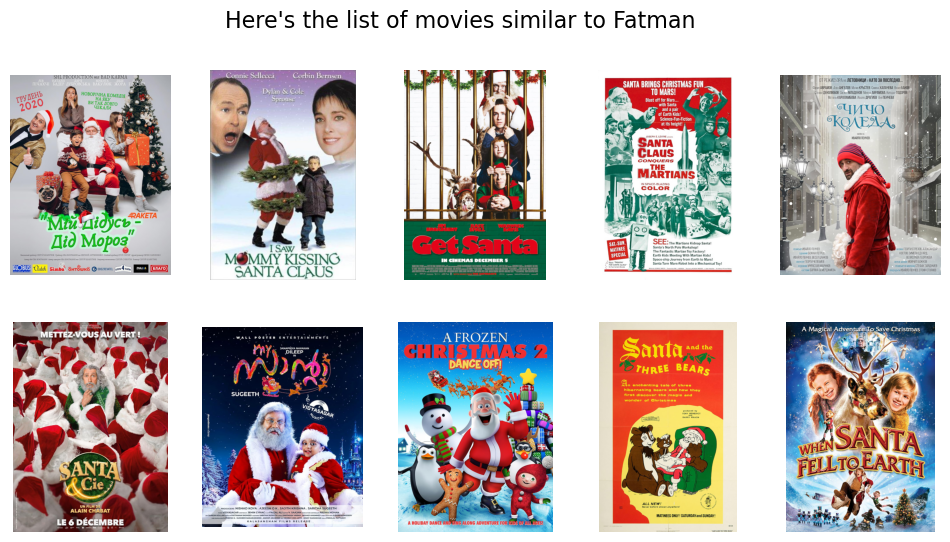

In [33]:
contents_based_recommender('Batman')

Even if the title I typed was not the same as what the data contains, it found the movie correctly and recommended the list well.
